<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script> 
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3.0.1/es5/tex-mml-chtml.js"></script>

# Figure 4: The lytic transglycosylase BB0259 is responsible for anhydromuropeptide release in culture supernatant

This code analyzes the results from one experiment querying the supernatants of LTGase strains grown to 3 days into stationary phase, sampled at days 1 and 3. We analyze here the cultures 3 days into stationary phase. 
- file names in the directory have the organization: SampleNumber_Condition_Day_BiologicalReplicate. For example, one name is 13_611_3_1.pkl. 
  - SampleNumber (when it was run on QTOF): 13
  - Condition: 611 (CJW strain number)
  - Day: 3 (supernatants were collected on 1 and 3 days)
  - BiologicalReplicate: 1 (total of 3 biological replicates per condition and day.)
- Conditions are defined below. 
  - BSK: media-only control, BSK-II
  - 611: parent strain, B31-A
  - 612: B31-A $\Delta$*bb0531*. Knockout of putative LTGase 1. 
  - 613: B31-A $\Delta$*bb0259*. Knockout of putative LTGase 2.
  - 614: B31-A $\Delta$*bb0259*//pBSV2G-P $_\text{flgB}$-*bb0259*. Complement of 613.

The strategy is to construct EICs of the supernatants, integrate the peaks, then plot them as bar graphs. 

Experiment, analysis, and code completed by Joshua W. McCausland, CJW lab.

In [14]:
import numpy as np
import pandas as pd
from pymzml.run import Reader
from matplotlib import pyplot as plt,ticker
import seaborn as sns
plt.rcParams["font.family"] = "Arial" #Set global font to arial
import glob,os
import warnings
warnings.filterwarnings("ignore")

# My custom to make extracted ion chromatograms. 
# Feed a pickle dataframe (converted mzML to pandas), specify the mass to search with an error (ppm).
# returns a pandas Series, which can be appended to parent dataframe as a new column.
def refine_mass(df,ppm = 20,mass_to_search = 0):
    low_mass = mass_to_search - (ppm*mass_to_search/1e6)
    high_mass = mass_to_search + (ppm*mass_to_search/1e6)
    result = df.apply(lambda row: np.sum(row.peaks[np.where(np.logical_and(row.mz >= low_mass, row.mz <= high_mass))]) if row.peaks[np.where(np.logical_and(row.mz > low_mass, row.mz < high_mass))].shape[0] > 0 else 0,axis=1)
    return result

experiment_directory = '/Volumes/Data_05/Shares/Data_05/Josh_McCausland/Projects/Bb_PG_Shedding/LCMS/20240313-pg-digest_and_ltgase'

This is the generic code I use to convert open-source mzML files to pandas dataframes and save them as pickles. 

In [ ]:
FileList = glob.glob('mzML_data/*.mzML')
for file in FileList:
    filename = os.path.basename(file).removesuffix('.mzML')
    run = Reader(file)
    run_df = pd.DataFrame({'scanID': [key for key in run.info['offset_dict'].keys() if str(key).isnumeric()]})
    run_df['time'] = run_df.scanID.apply(lambda row: run[row].scan_time_in_minutes())
    run_df['mz'] = run_df.scanID.apply(lambda row: run[row].mz)
    run_df['peaks'] = run_df.scanID.apply(lambda row: run[row].centroidedPeaks)
    run_df['peaks'] = run_df.peaks.apply(lambda row: np.column_stack(row)[1] if row.shape[0] > 0 else row)
    run_df.to_pickle(f'pickle_data/{filename}.pkl')

Here, we load the EICs for the PG species with GlcNAc-AnhMurNAc. Areas highlighted in red indicate the time windows that are summed for quantifying EICs. 

Text(0.5, 0, 'Retention time (min)')

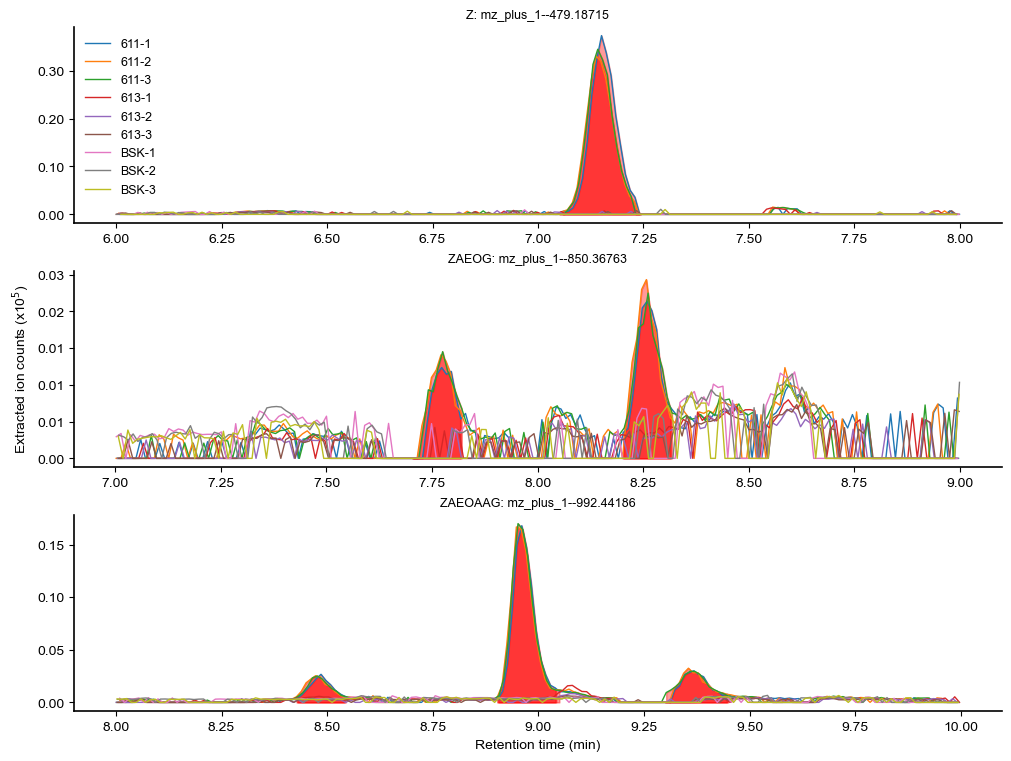

In [17]:
# editable components for the code. 
# specify the species of interest. 
species_to_plot = ['Z','ZAEOG','ZAEOAAG']

# the day of the culture (1 or 3).
day = 3

# time windows for displaying axes.
time_windows = {
    'Z': [6,8],
    'ZAEOG': [7,9],
    'ZAEOAAG': [8,10]
}

#Create a dictionary specifying the time window for peaks of interest. These will be shaded red.
peak_windows = {
    'Z': [[7.05,7.25]],
    'ZAEOG': [[7.7,7.825],[8.2,8.325]],
    'ZAEOAAG': [[8.425,8.55],[8.9,9.05],[9.3,9.45]]
}

######################################
def y_fmt(x, y):
    return f'{(x/1e5):<2.2f}'.format(x).split('e')[0]

# load the PG reference file and select the ones of interesthere. 
reference_df = pd.read_pickle(f'included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
reference_df = reference_df[reference_df.Species.isin(species_to_plot)]

# select the groups of various conditions for plotting. 
bsk = glob.glob(f'{experiment_directory}/pickle_data/*BSK_1_*.pkl')
wild_type = glob.glob(f'{experiment_directory}/pickle_data/*611_{day}*.pkl')
other = glob.glob(f'{experiment_directory}/pickle_data/*612_{day}*.pkl')
knockout = glob.glob(f'{experiment_directory}/pickle_data/*613_{day}*.pkl')
rescue = glob.glob(f'{experiment_directory}/pickle_data/*614_{day}*.pkl')

# the file list to iterature through, chosen from above.
filelist = wild_type + knockout + bsk


fig,axs = plt.subplots(nrows = len(species_to_plot),figsize = (10,2.5*len(species_to_plot)),layout = 'constrained')
for file in filelist:
    rundf = pd.read_pickle(file)
    filename = os.path.basename(file).removesuffix('.pkl')
    strain = filename.split('_')[1]
    replicate = filename.split('_')[3] 

    # create EICs for all species of interest.
    for _,row in reference_df.iterrows():
        rundf[row.Species] = refine_mass(rundf,mass_to_search=row.mz_plus_1,ppm=20)
    for ax,species in zip(axs,species_to_plot):
        time_window = time_windows[species]
        df_subset = rundf[rundf.time.between(time_window[0],time_window[1])].reset_index()
        ax.plot(df_subset.time,df_subset[species],linewidth = 1,label = f'{strain}-{replicate}')

        # color in only the parent sample areas to illustrate what the peak windows are summing.
        if strain == '611':
            for peak_window in peak_windows[species]:
                time_window = df_subset[df_subset.time.between(peak_window[0],peak_window[1])]
                ax.fill_between(time_window.time,time_window[species],alpha=0.4,color='red')

        ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
        ax.set_title(f'{species}: mz_plus_1--{reference_df[reference_df.Species == species].mz_plus_1.values[0]:.5f}',fontsize=9)
        ax.spines[['right','top']].set_visible(False)
        ax.spines[['left','bottom']].set_linewidth(1.2)

axs[0].legend(loc = 'upper left',frameon = False,fontsize=9)
axs[1].set_ylabel('Extracted ion counts (x10$^5$)')
axs[-1].set_xlabel('Retention time (min)')

Using the example above, we sum all the areas under the defined time windows (shaded red) instead of plotting them. 

In [12]:
# define the PG species. 
species_to_plot = ['Z','ZAEOG','ZAEOAAG']

# define the peak windows for summing.
peak_windows = {
    'Z': [[7.05,7.25]],
    'ZAEOG': [[7.7,7.825],[8.2,8.325]],
    'ZAEOAAG': [[8.425,8.55],[8.9,9.05],[9.3,9.45]]
}

# load the reference dataframe and select the species I wish to make EICs of.
reference_df = pd.read_pickle(f'included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
reference_df = reference_df[reference_df.Species.isin(species_to_plot)]

# define the file lists for each experimental condition.
bsk = glob.glob(f'{experiment_directory}/pickle_data/*BSK*.pkl')
wild_type = glob.glob(f'{experiment_directory}/pickle_data/*611*.pkl')
other = glob.glob(f'{experiment_directory}/pickle_data/*612*.pkl')
knockout = glob.glob(f'{experiment_directory}/pickle_data/*613*.pkl')
rescue = glob.glob(f'{experiment_directory}/pickle_data/*614*.pkl')

# prepare teh file list in the order I wish.
filelist = bsk + wild_type + other + knockout + rescue

signal_df = pd.DataFrame()
idx = 0
for file in filelist:
    rundf = pd.read_pickle(file)
    filename = os.path.basename(file).removesuffix('.pkl')
    strain = filename.split('_')[1]
    day = filename.split('_')[2]
    replicate = filename.split('_')[3] 
    for _,row in reference_df.iterrows():
        rundf[row.Species] = refine_mass(rundf,mass_to_search=row.mz_plus_1,ppm=20)
    for species in species_to_plot:     

        # some species have multiple peaks (like ZAEOAAG). Iterate through each peak and sum.
        sum_values = []
        for peak_window in peak_windows[species]:
            time_window = rundf[rundf.time.between(peak_window[0],peak_window[1])]
            sum_values.append(time_window[species].sum())

        temp_df = pd.DataFrame({
            'strain': strain,
            'label': filename.split('_')[0],
            'day': int(day),
            'replicate': int(replicate),
            'species': species,
            'value': np.sum(sum_values)
        },index = [idx])
        idx += 1
        signal_df = pd.concat([signal_df,temp_df])

# show the pentapeptide species as an example of the final dataframe.
display(signal_df[(signal_df.species == 'ZAEOAAG')])

,strain,label,day,replicate,species,value
2,BSK,10,1,1,ZAEOAAG,11439.516174
5,BSK,11,1,2,ZAEOAAG,10776.219238
8,BSK,12,1,3,ZAEOAAG,9344.394547
11,611,13,3,1,ZAEOAAG,125014.696442
14,611,14,3,2,ZAEOAAG,130685.352264
17,611,15,3,3,ZAEOAAG,132128.644287
20,612,16,3,1,ZAEOAAG,108489.488068
23,612,17,3,2,ZAEOAAG,111022.762390
26,612,18,3,3,ZAEOAAG,109317.366791
29,613,23,3,1,ZAEOAAG,11887.496017


Now that a single dataframe with integrated ion intensities is prepared, plot them as bar plots.

Text(-1.3885555555555609, 0.5, 'Extracted ion counts (x10$^4$)')

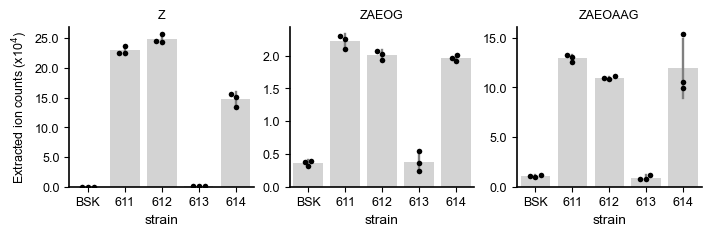

In [13]:
# for defining the y scale.
def y_fmt(x, y):
    return f'{(x/1e4):<2.1f}'.format(x).split('e')[0]

# the order of each of the categories. See figure preamble for condition definitions.
order = ['BSK','611','612','613','614']

# the order of the plots by PG species.
plot_order = ['Z','ZAEOG','ZAEOAAG']

fig,axs = plt.subplots(ncols = len(signal_df.species.unique()),figsize = (7,2.25),layout = 'constrained')
for _ax,_species in zip(axs,plot_order):

    #subset the dataframe by the species of interest, then pivot it such that the columns are strain. For easy plotting.
    signal_df_subset = signal_df[signal_df.species == _species].pivot_table(values='value',columns='strain',index='replicate')

    # order the columns by the plot order above.
    signal_df_subset = signal_df_subset[order]

    #plot.
    sns.barplot(data=signal_df_subset,ax=_ax,color = 'lightgray',errcolor='gray',errwidth=1.7,errorbar='sd')
    sns.swarmplot(data=signal_df_subset,color='black',ax=_ax,size=4)
    _ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
    _ax.tick_params(axis='both',labelsize=9)
    _ax.spines[['right','top']].set_visible(False)
    _ax.spines[['left','bottom']].set_linewidth(1.2)
    _ax.set_title(_species,fontsize=9)

axs[0].set_ylabel('Extracted ion counts (x10$^4$)',fontsize=9)